In [198]:
%matplotlib inline
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))

from tools import utils
from data import goes16s3

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import time
import os
from PIL import Image

import torch

import cv2

In [199]:
n_channels = 8

dayofyear = 284 #dt.datetime(year, 3, 4).timetuple().tm_yday
year = 2012

#dayofyear = dt.datetime(2017, 9, 6).timetuple().tm_yday
#year = 2017

figure_directory = 'figures/network-architecture/'
if not os.path.exists(figure_directory):
    os.makedirs(figure_directory)

In [200]:
noaadata = goes16s3.NOAAGOESS3(product='ABI-L1b-RadM', channels=range(1,n_channels+1),
                               save_directory='/raid/tj/GOES/TEST/')

#noaa.download_day(year, dayofyear)
files = noaadata.local_files()
print(files)
I0files = files.loc[year, dayofyear, 18, 2].values[0,:n_channels]
I1files = files.loc[year, dayofyear, 18, 2+15].values[0,:n_channels]

print(I1files)

I0 = goes16s3._open_and_merge_2km(I0files)
I1 = goes16s3._open_and_merge_2km(I1files)

                                                                                        file  \
channel                                                                                    1   
year dayofyear hour minute second spatial                                                      
2018 63        12   0      272    RadM1    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/00...   
                           572    RadM2    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/00...   
                    1      272    RadM1    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/01...   
                           572    RadM2    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/01...   
                    2      272    RadM1    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/02...   
                           572    RadM2    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/02...   
                    3      272    RadM1    /raid/tj/GOES/TEST/ABI-L1b-RadM/2018/063/12/03...   
                           572    RadM2 

KeyError: u'the label [2012] is not in the [index]'

In [203]:
def plot_3channel_image(x, img_file=None):
    x_img = x.detach().numpy()[0][[1,2,0]]
    x_img = np.transpose(x_img, (1,2,0))
    if img_file is not None:
        plt.imsave(img_file, x_img)
        
    plt.imshow(x_img)
    plt.axis('off')
    plt.show()
    
def plot_1channel_image(x, img_file=None, cmap=None, vmin=None, vmax=None):
    x_img = x.detach().numpy()[0,0]
    if img_file is not None:
        plt.imsave(img_file, x_img, cmap=cmap, vmin=vmin, vmax=vmax)
        
    plt.imshow(x_img, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.axis('off')
    plt.show()

def plot_2channel_image(x, img_file=None):
    img1 = x.detach().numpy()[0,0]
    img2 = x.detach().numpy()[0,1]
    
    img = np.concatenate([img1, img2], axis=1)
    if img_file is not None:
        plt.imsave(img_file, img)
        
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
def opticalflow(flow):
    hsv = np.ones((flow.shape[0], flow.shape[1], 3))*255.
    
    # Use Hue, Saturation, Value colour model 
    mag, ang = cv2.cartToPolar(flow[:,:,0], flow[:,:,1])
    return ang

    hsv[:,:, 0] = ang * 180 / np.pi / 2
    hsv[:,:, 2] = cv2.normalize(mag, None, 0, 255., cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(np.uint8(hsv), cv2.COLOR_HSV2BGR)
    return bgr

def plot_optical_flow(x, img_file=None):
    x = x.detach().numpy()[0]
    x = np.transpose(x, (1,2,0))
    bgr = opticalflow(x)
    if img_file is not None:
        plt.imsave(img_file, bgr)

    plt.imshow(bgr)
    plt.axis('off')
    plt.show()



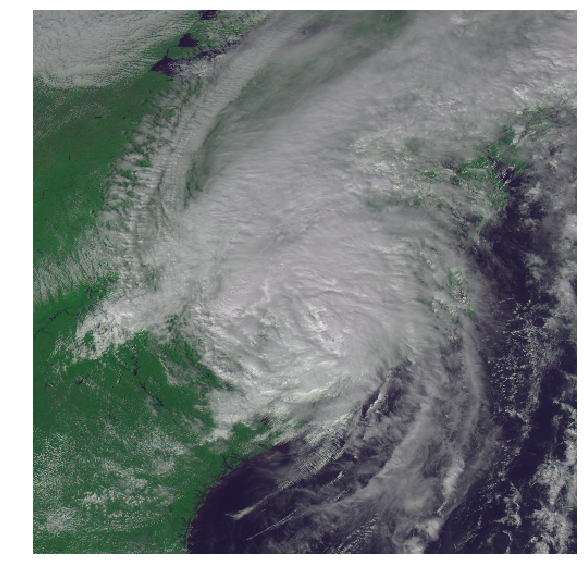

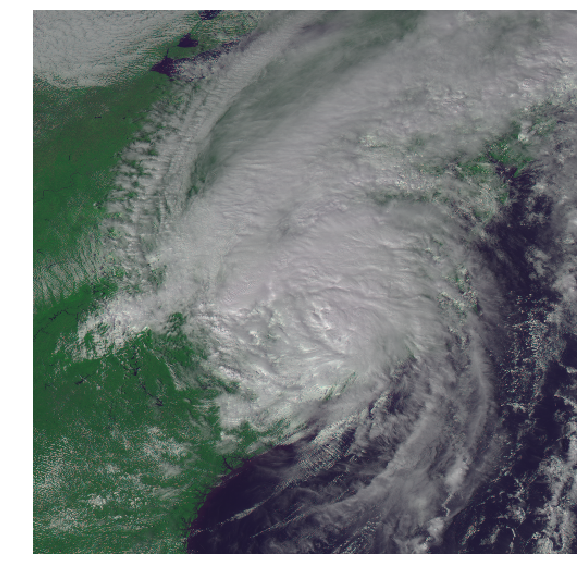

/home/tj/.local/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
/home/tj/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in sqrt
/home/tj/.local/lib/python2.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
/home/tj/.local/lib/python2.7/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


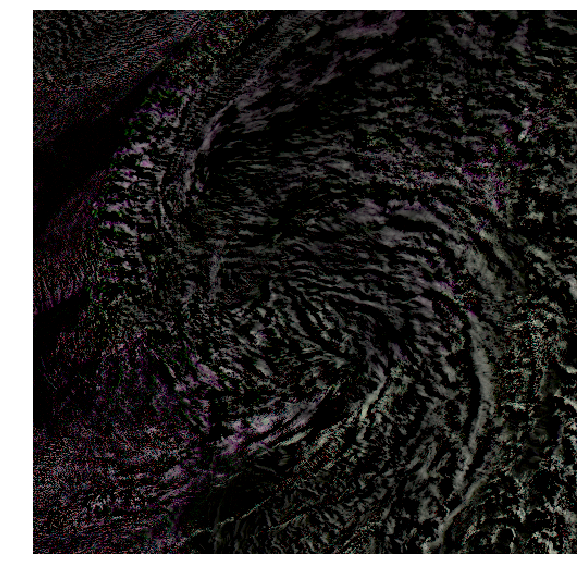

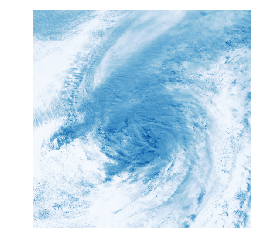

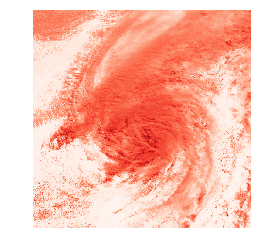

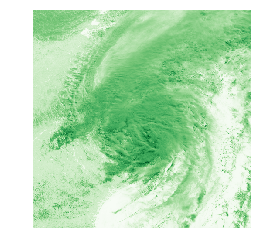

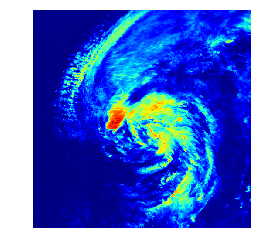

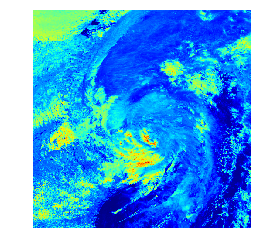

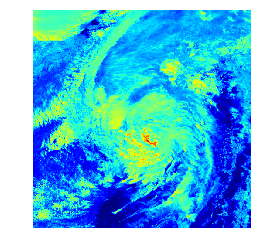

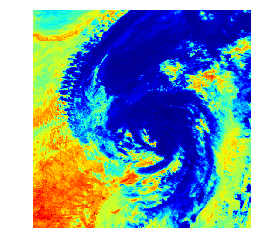

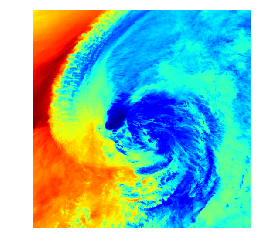

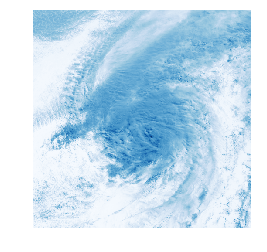

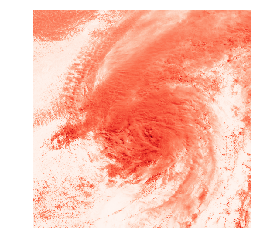

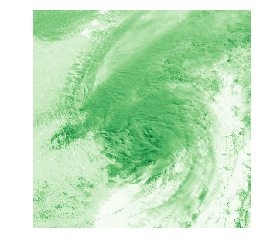

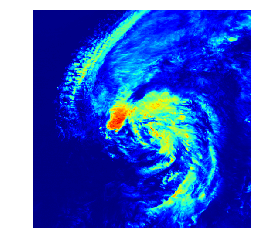

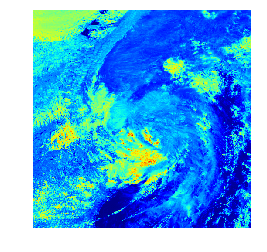

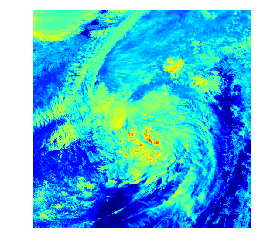

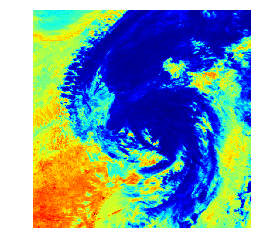

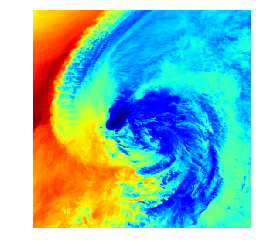

In [208]:
if not os.path.exists('figures/network'):
    os.makedirs('figures/network')
    

I0_sub = I0#.sel(x=slice(-0.04,-0.01), y=slice(0.10,0.07))
I1_sub = I1#.sel(x=slice(-0.04,-0.01), y=slice(0.10,0.07))

rgb0 = np.transpose(I0_sub.values[[1,2,0]], (1,2,0))
#rgb = np.transpose(I0_sub.values[[6,4,5]], (1,2,0))


plt.figure(figsize=(10,10))
plt.imshow(rgb0**0.75)#, vmin=0.0, vmax=0.34)
plt.imsave('figures/network/I0.png', rgb0**0.75)
plt.axis('off')
plt.show()

rgb1 = np.transpose(I1_sub.values[[1,2,0]], (1,2,0))
plt.figure(figsize=(10,10))
plt.imshow(rgb1**0.75)#, vmin=0.0, vmax=0.34)
plt.imsave('figures/network/I1.png', rgb1**0.75)
plt.axis('off')
plt.show()


plt.figure(figsize=(10,10))
plt.imshow((rgb1-rgb0)**0.5)#, vmin=0.0, vmax=0.34)
plt.imsave('figures/network/I1-minus-I0.png', (rgb1-rgb0)**0.5)
plt.axis('off')
plt.show()


cmaps = ['Blues', 'Reds', 'Greens', 'jet', 'jet', 'jet', 'jet', 'jet']
for i in range(len(I0_sub)):
    plt.imshow(I0_sub[i], cmap=cmaps[i])
    plt.axis('off')
    plt.imsave('figures/network/I0_%i.png' % i, I0_sub[i], cmap=cmaps[i])
    plt.show()
    
for i in range(len(I1_sub)):
    plt.imshow(I1_sub[i], cmap=cmaps[i])
    plt.axis('off')
    plt.imsave('figures/network/I1_%i.png' % i, I1_sub[i], cmap=cmaps[i])
    plt.show()    

In [209]:
from tools import inference_tools
'../saved-models/9Min-3Channels-LambdaW_0.10-LambdaS_0.10-Batch20_MV/'
model_path = '../saved-models/9Min-%iChannels-LambdaW_0.10-LambdaS_0.10-Batch20_MV2' % n_channels
flownet, interpnet, warper = inference_tools.load_models(n_channels, model_path, True)

loading checkpoint ../saved-models/9Min-8Channels-LambdaW_0.10-LambdaS_0.10-Batch20_MV2/checkpoint.flownet.mv.pth.tar
=> loaded checkpoint '../saved-models/9Min-8Channels-LambdaW_0.10-LambdaS_0.10-Batch20_MV2/checkpoint.flownet.mv.pth.tar' (epoch 49)


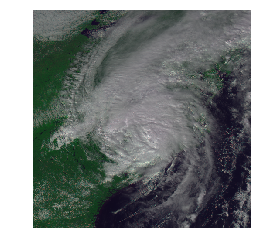

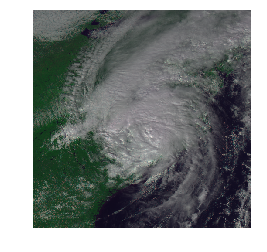

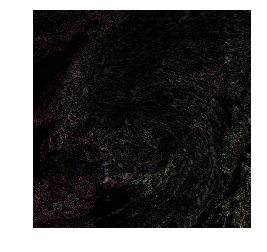

(torch.Size([1, 32, 500, 500]), torch.Size([1, 16, 500, 500]))


In [210]:
I0_torch = torch.from_numpy(I0_sub.values[np.newaxis])
I1_torch = torch.from_numpy(I1_sub.values[np.newaxis])

plot_3channel_image(I0_torch, os.path.join(figure_directory, 'I0.png'))
plot_3channel_image(I1_torch, os.path.join(figure_directory, 'I1.png'))
plot_3channel_image(torch.abs(I1_torch-I0_torch), os.path.join(figure_directory, 'I1-minus-I0.png'))

f = flownet(I0_torch.cuda(), I1_torch.cuda())
_n = I0_sub.shape[1]

n_flows = int(f.shape[1]/2)
f_01 = f[:,:n_flows]
f_10 = f[:,n_flows:]
print(f.shape, f_01.shape)

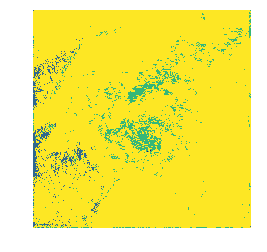

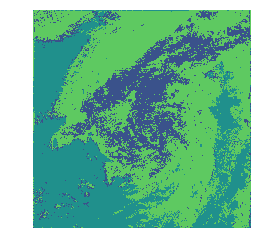

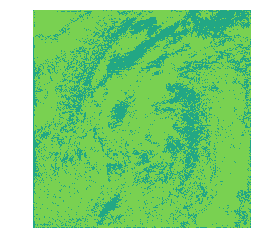

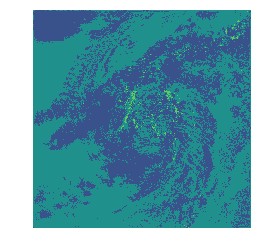

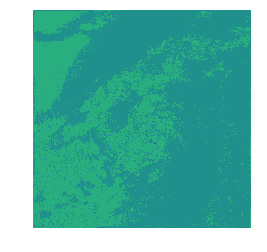

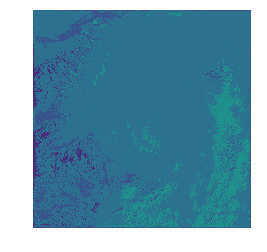

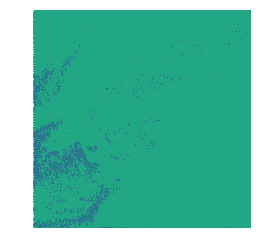

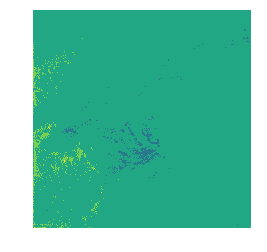

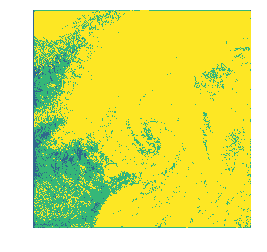

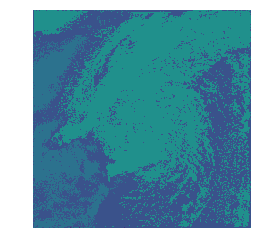

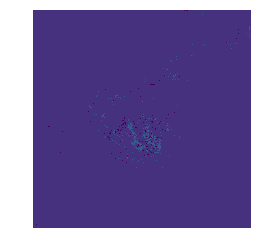

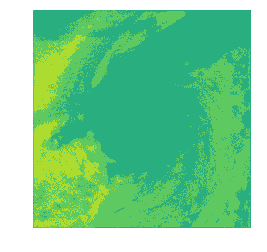

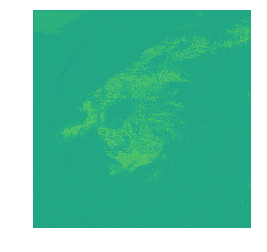

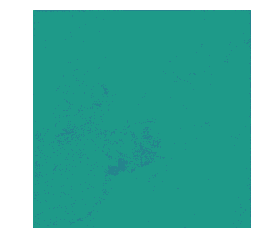

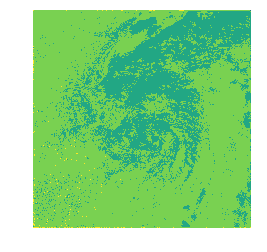

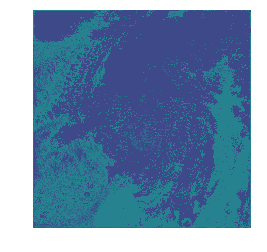

(array([1000000,  250000,       0,       0,       0,       0,  500000,
         250000,  250000, 1750000]),
 array([-0.36494654, -0.2885783 , -0.21221007, -0.13584183, -0.0594736 ,
         0.01689464,  0.09326287,  0.16963111,  0.24599935,  0.32236758,
         0.39873582], dtype=float32))

In [211]:
#plot_2channel_image(f_01, os.path.join(figure_directory, 'f_01.png'))
#plot_2channel_image(f_10, os.path.join(figure_directory, 'f_10.png'))
for ii in range(0, n_channels):
    plot_optical_flow(torch.abs(f_01[:,ii*2:].cpu()), os.path.join(figure_directory, 'f_01.png'))
    plot_optical_flow(torch.abs(f_10[:,ii*2:].cpu()), os.path.join(figure_directory, 'f_10.png'))

x = f_01.cpu().detach().numpy()
x = x[np.isfinite(x)]
np.histogram(x)

In [212]:
t = 0.5
I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(I0_torch.cuda(), I1_torch.cuda(), 
                                                            f_01, f_10, t)

f_t0 = -(1-t) * t * f_01 + t**2 * f_10
f_t0 += delta_f_t0

f_t1 = (1-t)**2 * f_01 - t*(1-t) * f_10
f_t1 += delta_f_t1

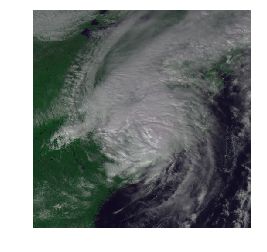

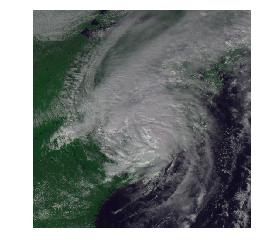

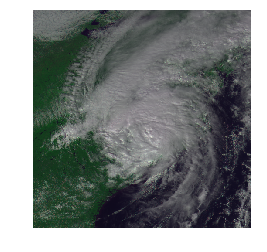

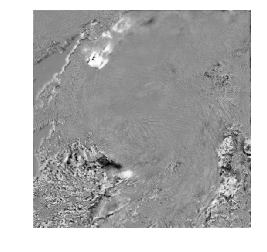

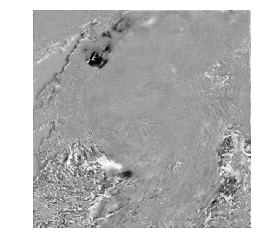

In [213]:
plot_3channel_image(I_t.cpu(), os.path.join(figure_directory, 'It.png'))

plot_3channel_image(g0.cpu(), os.path.join(figure_directory, 'g0.png'))
plot_3channel_image(g1.cpu(), os.path.join(figure_directory, 'g1.png'))

plot_1channel_image(V_t0.cpu(), os.path.join(figure_directory, 'V_t0.png'), cmap='Greys')
plot_1channel_image(1-V_t0.cpu(), os.path.join(figure_directory, 'V_t1.png'), cmap='Greys')

In [ ]:


ts = np.arange(1/15., 15/15., 1/15.)
ts =[0.10, 0.25, 0.5, 0.75, .90]

visibles = []
left = []
right = []
prediction = []
flow_t0 = []
flow_t1 = []

for t in ts:
    I_t, g0, g1, V_t0, V_t1, delta_f_t0, delta_f_t1 = interpnet(I0_torch.cuda(), I1_torch.cuda(), 
                                                            f_01, f_10, t)
    
    f_t0 = -(1-t) * t * f_01 + t**2 * f_10
    f_t0 += delta_f_t0

    f_t1 = (1-t)**2 * f_01 - t*(1-t) * f_10
    f_t1 += delta_f_t1
    
    visibles.append(V_t0.cpu().detach().numpy()[0,0,-175:-75,125:225])

    x_img = (V_t0*I_t*2).cpu().detach().numpy()[0,:,-175:-75,125:225]
    x_img = x_img[[1,2,0]]
    x_img = np.transpose(x_img, (1,2,0)) 
    left.append(x_img)
    
    
    x_img = (V_t1*I_t*2).cpu().detach().numpy()[0,:,-175:-75,125:225]
    x_img = x_img[[1,2,0]]
    x_img = np.transpose(x_img, (1,2,0)) 
    right.append(x_img)
    
    x_img = (I_t).cpu().detach().numpy()[0,:,-175:-75,125:225]
    x_img = x_img[[1,2,0]]
    x_img = np.transpose(x_img, (1,2,0)) 
    prediction.append(x_img)    
    
    x_img = f_t0[:,:].cpu()
    x_img = x_img.detach().numpy()[0]
    x_img = np.transpose(x_img, (1,2,0))
    bgr = opticalflow(x_img)
    flow_t0.append(bgr)
    
    x_img = f_t1[:,:].cpu()
    x_img = x_img.detach().numpy()[0]
    x_img = np.transpose(x_img, (1,2,0))
    bgr = opticalflow(x_img)
    flow_t1.append(bgr)    

(-0.5, 2499.5, 499.5, -0.5)

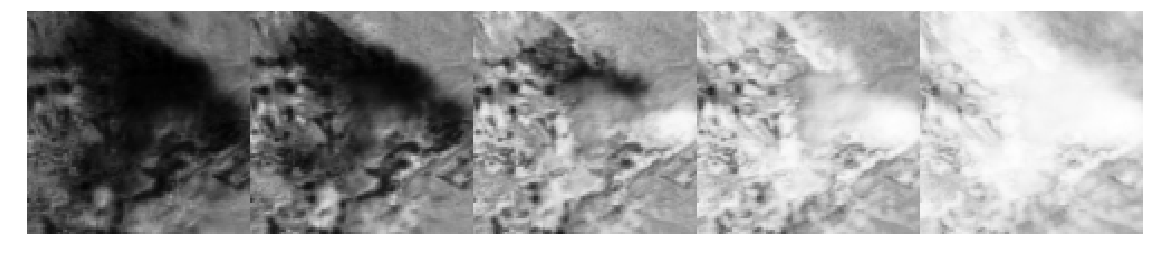

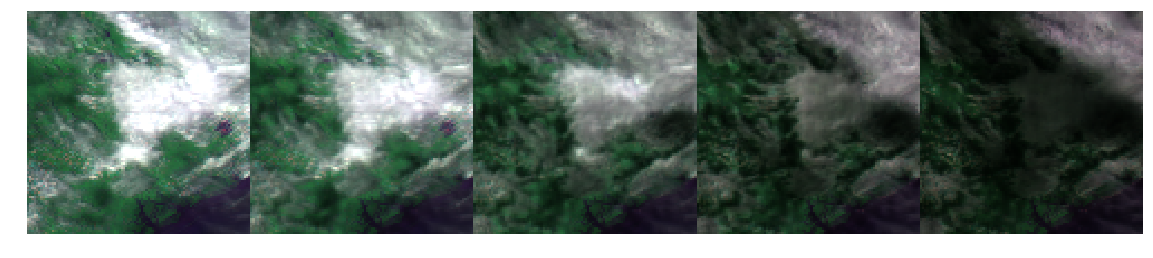

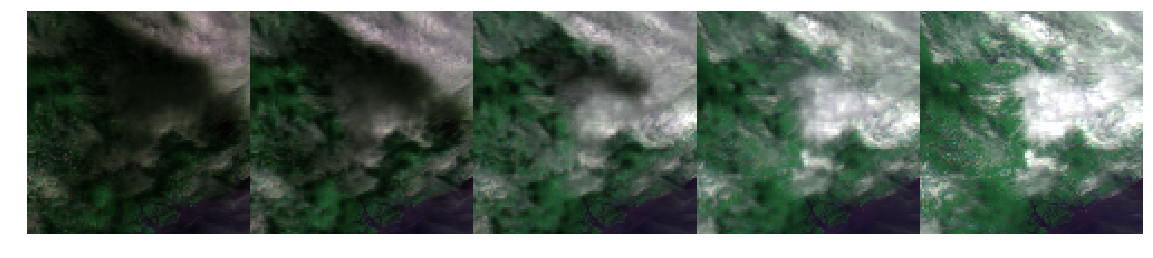

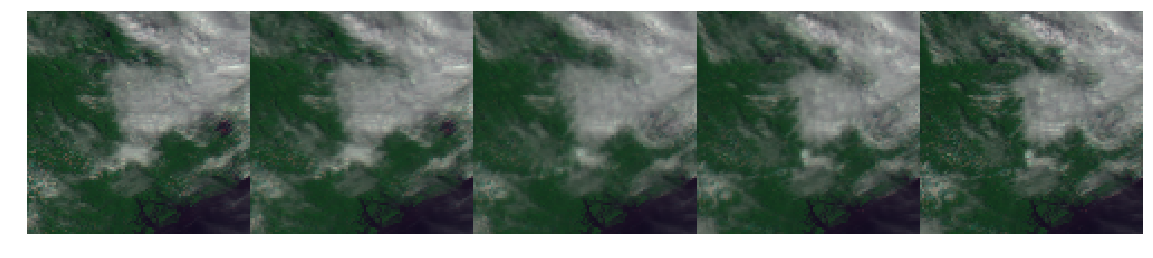

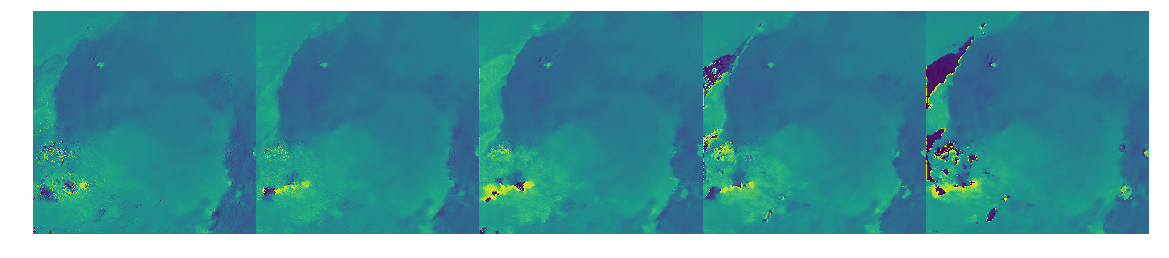

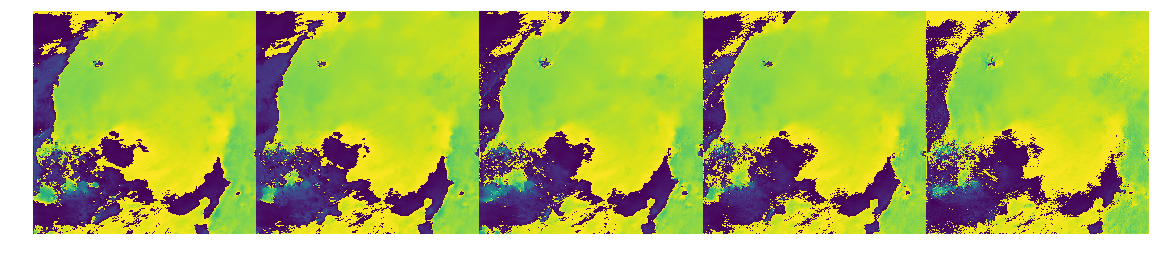

In [201]:
if not os.path.exists("figures/visibility"):
    os.makedirs("figures/visibility")

plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/vt0.png', np.concatenate(visibles, axis=1), cmap='Greys', dpi=200)
plt.imshow(np.concatenate(visibles, axis=1), cmap='Greys')
plt.axis('off')

plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/left.png', np.concatenate(left, axis=1), dpi=300)
plt.imshow(np.concatenate(left, axis=1))
plt.axis('off')

plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/right.png', np.concatenate(right, axis=1), dpi=300)
plt.imshow(np.concatenate(right, axis=1))
plt.axis('off')

plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/predictions.png', np.concatenate(prediction, axis=1), dpi=300)
plt.imshow(np.concatenate(prediction, axis=1))
plt.axis('off')


plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/flow_t0.png', np.concatenate(flow_t0, axis=1), dpi=300)
plt.imshow(np.concatenate(flow_t0, axis=1))
plt.axis('off')

plt.figure(figsize=(20,8))
plt.imsave('figures/visibility/flow_t1.png', np.concatenate(flow_t1, axis=1), dpi=300)
plt.imshow(np.concatenate(flow_t1, axis=1))
plt.axis('off')

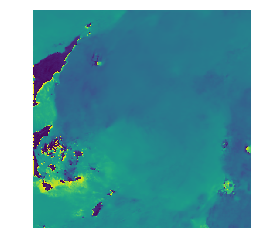

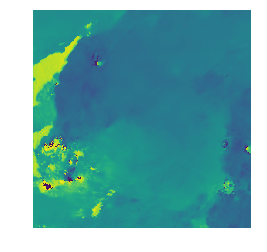

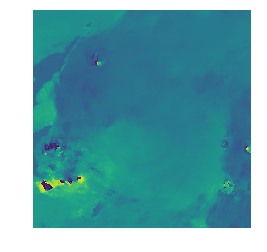

In [202]:
plot_optical_flow(f_t0[:,:].cpu(), os.path.join(figure_directory, 'd_f_t0.png'))
#plot_optical_flow(f_t1[:,2:].cpu(), os.path.join(figure_directory, 'd_f_t1.png'))

plot_optical_flow(f_t0[:,8:].cpu(), os.path.join(figure_directory, 'd_f_t0.png'))
#plot_optical_flow(f_t1[:,12:].cpu(), os.path.join(figure_directory, 'd_f_t1.png'))

plot_optical_flow(f_t0[:,12:].cpu(), os.path.join(figure_directory, 'd_f_t0.png'))
#plot_optical_flow(f_t1[:,4:].cpu(), os.path.join(figure_directory, 'd_f_t1.png'))